## Pré-processamento e explocação do Modelo de Classificação
<a href="https://colab.research.google.com/github/caesarcc/python-tcc-url-fakenews-check/blob/main/jupyter/classificacao_passo01_pre_processamento_exploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir no Colab"/></a>

In [1]:
# Importação de bibliotecas utilizadas no pré-processamento
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display
%matplotlib inline

### Baixar os dados do [Fake.br-Corpus](https://github.com/roneysco/Fake.br-Corpus)

*Atenção:* Para rodar localmente, é preciso salvar o pacote Fake.br-Corpus no diretorio do projeto.

In [ ]:
!git clone https://github.com/roneysco/Fake.br-Corpus

Cloning into 'Fake.br-Corpus'...
remote: Enumerating objects: 28763, done.
remote: Total 28763 (delta 0), reused 0 (delta 0), pack-reused 28763
Receiving objects: 100% (28763/28763), 37.10 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (14129/14129), done.
Checking out files: 100% (21602/21602), done.


### Carregando os dados

Vou utilizar a amostra "size_normalized_texts" do Corpus dado que ela ajuda a evitar viéses no treino, conforme informação disponível na documentação. Cada par de texto verdadeiro ou falso possui a mesma quantidade de palavras, truncando o maior pelo menor.

In [2]:
DADOS_CAMINHO = "./Fake.br-Corpus/size_normalized_texts"

def load_txts(path):
    txts = []
    for filename in sorted(os.listdir(path), key=lambda x: int(re.match("[0-9]+", x).group())):
        with open(os.path.join(path, filename)) as f:
            txts.append(f.read())
    return [txt.rstrip() for txt in txts]

true_txts = load_txts(os.path.join(DADOS_CAMINHO, "true"))
fake_txts = load_txts(os.path.join(DADOS_CAMINHO, "fake"))

#confere se tem a mesma quantidade (dataset é balanceado)
assert(len(true_txts) == len(fake_txts))

dados = pd.DataFrame(
    [{"texto": t, "classe": 0} for t in true_txts] \
         + [{"texto": f, "classe": 1}  for f in fake_txts]
)
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados[dados['texto'].str.len()<150].sample(n=3)[['classe', 'texto']])

,classe,texto
695,0,Imagens da semana de 9 a 15 de dezembro de 2017.
479,0,"Hospital de Base transforma Rio Preto em referência médica no país. Por ano, o complexo faz quase 650 mil atendimentos, que ainda tem Hospital"
4556,1,"Desembargador acusado de pedir propina gravou um vídeo ""nu"" dizendo que apanhou da mulher. FATO 1. Vamos tentar resumir os fatos rapidamente:"


### Exploração e limpeza de dados

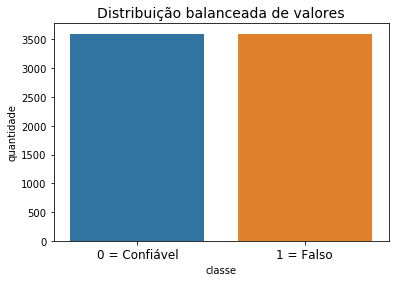

In [3]:
ax = sns.countplot(x="classe", data=dados)
ax.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
ax.set_title('Distribuição balanceada de valores', fontsize=14)
ax.set_ylabel('quantidade')
plt.show()

In [6]:
def contar(texto):
    qtdes = []
    for linha in texto:
        qtdes.append(len(re.findall(r"[\w']+|[.,!?;:/\"]", linha)))
    return np.array(qtdes)

def distribiucao_palavras(dados, campo, titulo):
    contagem = contar(dados[campo].values)
    intervalo = list(range(0, 601, 50))

    plt.figure(figsize=(10,5))
    plt.rcParams.update({'font.size': 14})
    plt.hist(contagem, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervalo)
    plt.xticks(intervalo)
    plt.title(titulo)
    plt.xlabel("Qtde palavras ou pontuação", fontsize=14, fontweight="bold")
    plt.ylabel("Frequência", fontsize=14, fontweight="bold")

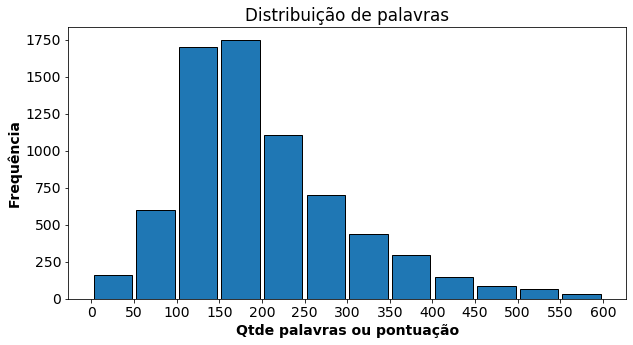

In [7]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras")

In [9]:
# Limpar textos
def limpar_textos(texto):
    texto = str(texto).replace(r'http[\w:/\.]+', ' ')  # remover urls
    texto = str(texto).replace(r'[^\.\w\s]', ' ')  # remover tudo exceto caracters e pontuação
    texto = str(texto).replace('[^a-zA-Z]', ' ')
    texto = str(texto).replace(r'\s\s+', ' ')
    # Correções específicas
    texto = str(texto).replace(". .", ".").replace(r'\n', '').replace('\n', '')
    # Correção das pontuações duplicadas, há muitos casos no dadaset
    texto = re.sub(r'(\W)(?=\1)', '', str(texto))
    return texto.strip()

dados["texto_limpo"] = dados.texto.apply(limpar_textos)
dados.sample(n=3)

,texto,classe,texto_limpo
6740,"ONU impõe sanções à Coréia e Kim Jong-un declara: ""Armem as ogivas. Usaremos a qualquer momento"". Kim Jong-un, o ditador norte-coreano ordenou que as ogivas nucleares do país estejam prontas par...",1,"ONU impõe sanções à Coréia e Kim Jong-un declara: ""Armem as ogivas. Usaremos a qualquer momento"". Kim Jong-un, o ditador norte-coreano ordenou que as ogivas nucleares do país estejam prontas para ..."
6596,Pão e Circo: Palácio do Planalto vira reduto do MST. Representantes do MST criticaram hoje (1º) o juiz Sergio Moro e incitaram a invasão de latifúndios no país. O que Dilma está fazendo com noss...,1,Pão e Circo: Palácio do Planalto vira reduto do MST. Representantes do MST criticaram hoje (1º) o juiz Sergio Moro e incitaram a invasão de latifúndios no país. O que Dilma está fazendo com nosso ...
2174,"Temer esteve com empresário, mas jamais tentou evitar delação, diz Planalto . Segundo jornal O Globo, dono da empresa JBS, Joesley Batista, gravou conversa com presidente na qual foi discutida a c...",0,"Temer esteve com empresário, mas jamais tentou evitar delação, diz Planalto . Segundo jornal O Globo, dono da empresa JBS, Joesley Batista, gravou conversa com presidente na qual foi discutida a c..."


In [10]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm

     ---------------------------------------- 22.2/22.2 MB 5.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


### Pré-processamento com Spacy
Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)   
Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 


In [11]:
import pt_core_news_sm
nlp = pt_core_news_sm.load()
# Remover stopwords e lematizar as setenças, a pontuação foi mantida token.is_punct (depois de testes de treino)
dados["texto_processado"] = dados.texto_limpo.apply(lambda texto: " ".join([token.lemma_ for token in nlp(texto) if not token.is_stop]))

In [13]:
# Confere resultados visualmente
dados.sample(n=3)

,texto,classe,texto_limpo,texto_processado
444,Príncipe imperial defende monarquia em MG e afirma que homossexualidade é um defeito. Dom Bertrand de Orleans e Bragança deu declaração polêmica em festival literário 130 anos após passagem de Dom...,0,Príncipe imperial defende monarquia em MG e afirma que homossexualidade é um defeito. Dom Bertrand de Orleans e Bragança deu declaração polêmica em festival literário 130 anos após passagem de Dom...,Príncipe imperial defender monarquia MG afirmar homossexualidade defeito . Dom Bertrand Orleans Bragança dar declaração polêmica festival literário 130 ano passagem Dom Pedro II Poços Caldas . tea...
1277,"Coreia do Norte lança míssil, mas teste falha, diz Seul. Casa Branca diz que presidente Trump foi informado. Míssil não deixou território norte-coreano, diz Comando dos EUA no Pacífico.. A Coreia ...",0,"Coreia do Norte lança míssil, mas teste falha, diz Seul. Casa Branca diz que presidente Trump foi informado. Míssil não deixou território norte-coreano, diz Comando dos EUA no Pacífico. A Coreia d...","Coreia Norte lançar míssil , testar falho , Seul . Casa Branca presidente Trump informar . Míssil deixar território norte-coreano , Comando EUA Pacífico . Coreia Norte testar míssil balístico sext..."
2421,Imaginava americanos com pelos grossos do peito dando volta no corpo: jovens exilados falam da vida na Coreia do Norte . Cidadãos de país mais fechado do planeta convivem com restrições e imagens ...,0,Imaginava americanos com pelos grossos do peito dando volta no corpo: jovens exilados falam da vida na Coreia do Norte . Cidadãos de país mais fechado do planeta convivem com restrições e imagens ...,"Imaginava americano grosso peitar dar voltar corpo : jovem exilar falir vidar Coreia Norte . Cidadãos país fechar planeta conviver restrição imagem distorcido exterior , norte-coreanos conseguir e..."


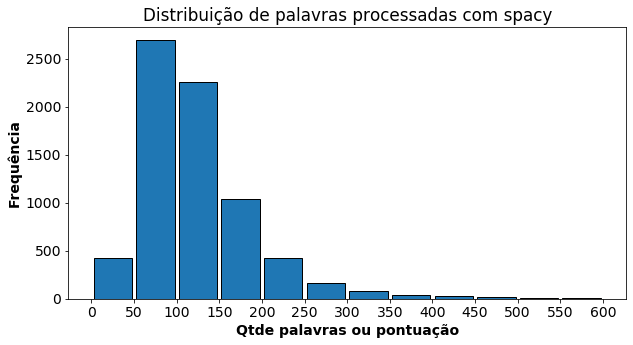

In [14]:
# A distribuição mudou e temo ter problemas de viés com a frases mais longas
distribiucao_palavras(dados, "texto_processado", "Distribuição de palavras processadas com spacy")

In [15]:
dados["qtde_texto_limpo"] = dados.texto_limpo.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados["qtde_texto_processado"] = dados.texto_processado.apply(lambda texto: len(re.findall(r"[\w']+|[.,!?;:/\"]", texto)))
dados.sample(n=3)

,texto,classe,texto_limpo,texto_processado,qtde_texto_limpo,qtde_texto_processado
600,"Retrospectiva 2017: os principais fatos do ano no Centro-Oeste de Minas. Explosões de caixas eletrônicos, morte de policiais, bilhete premiado da Mega-Sena, pedido de desculpas de Eduardo Costa, h...",0,"Retrospectiva 2017: os principais fatos do ano no Centro-Oeste de Minas. Explosões de caixas eletrônicos, morte de policiais, bilhete premiado da Mega-Sena, pedido de desculpas de Eduardo Costa, h...","Retrospectiva 2017 : principal fato ano Centro-Oeste Minas . Explosões caixa eletrônicos , morte policiar , bilhete premiar Mega-Sena , pedir desculpar Eduardo Costa , história sobrevivência . G1 ...",249,149
5907,"Agência internacional de notícias faz perfil de Galvão: ""Conhecido pelos desentendimentos com convidados"". A AP (Associated Press), uma agência internacional de notícias traçou um perfil do apre...",1,"Agência internacional de notícias faz perfil de Galvão: ""Conhecido pelos desentendimentos com convidados"". A AP (Associated Press), uma agência internacional de notícias traçou um perfil do aprese...","Agência internacional notícia perfil Galvão : "" desentendimento convidar "" . AP ( Associated Press ) , agência internacional notícia traçar perfil apresentador global . "" Alguém amo odiar "" comedi...",147,91
1703,"Imagens mostram irregularidades em presídio em Japeri, no RJ. Esquema fraudulento envolveria desvio de alimentos, venda de restos de comida, transporte ilegal de presos e uso de telefones por dete...",0,"Imagens mostram irregularidades em presídio em Japeri, no RJ. Esquema fraudulento envolveria desvio de alimentos, venda de restos de comida, transporte ilegal de presos e uso de telefones por dete...","Imagens mostrar irregularidade presídio Japeri , RJ . Esquema fraudulento envolver desviar alimento , vender resto comido , transportar ilegal preso usar telefone detentos . esquema fraudulento to...",186,118


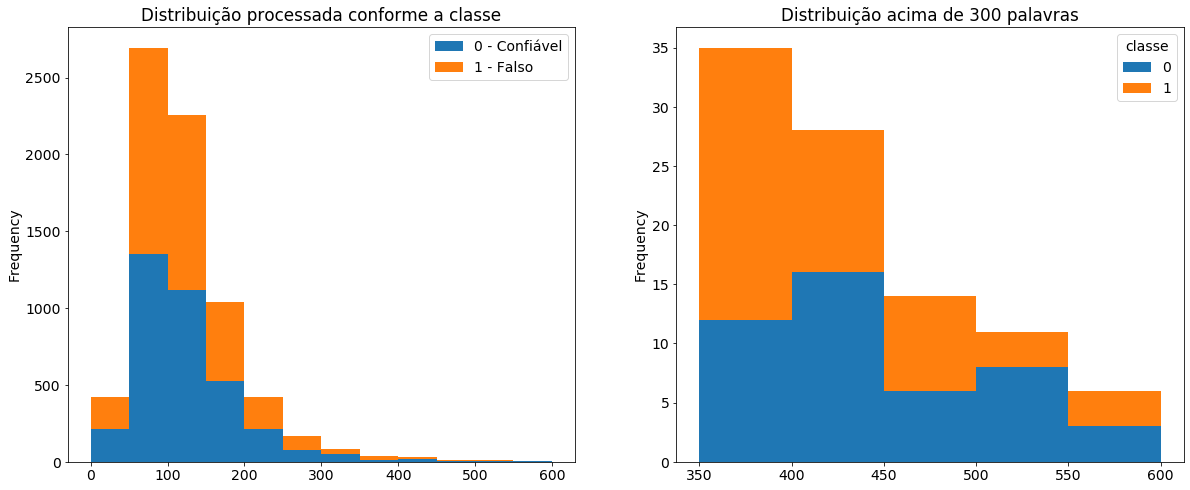

In [18]:
dfplot = dados.pivot(columns='classe').qtde_texto_processado
dfplot.columns = ['0 - Confiável', '1 - Falso']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes1 = dfplot.plot(
    ax=axes[0], kind='hist', stacked=True, bins=list(range(0, 601, 50)), 
    title="Distribuição processada conforme a classe")
evitar_bias = dados[dados['qtde_texto_processado'] > 350]
axes2 = evitar_bias.pivot(columns='classe').qtde_texto_processado.plot(
    ax=axes[1], kind='hist', stacked=True, bins=list(range(350, 601, 50)), 
    title="Distribuição acima de 300 palavras")

In [27]:
display(f"Total de amostras: {dados.shape[0]}", f"Amostras com muitas palavras: {evitar_bias.shape[0]}")
display("0 = Confiável;  1 = Falso")
display(evitar_bias.groupby('classe').qtde_texto_processado.count())

'Total de amostras: 7200'

'Amostras com muitas palavras: 107'

'0 = Confiável;  1 = Falso'

classe
0    51
1    56
Name: qtde_texto_processado, dtype: int64

In [35]:
# testes do ponto de corte para manter balanceamento
corte = 340
display(f"Amostras removidas: {dados[(dados['qtde_texto_processado'] > corte)].shape[0]}")
display(dados[(dados['qtde_texto_processado'] <= corte)].groupby('classe').qtde_texto_processado.count())

'Amostras removidas: 126'

classe
0    3537
1    3537
Name: qtde_texto_processado, dtype: int64

In [36]:
# Encontrei um ponto de corte que manteve o balanceamento perfeito da base
dados = dados[(dados['qtde_texto_processado'] <= corte)]

### Pesquisando se alguma palavra se destaca demais e pode gerar viés

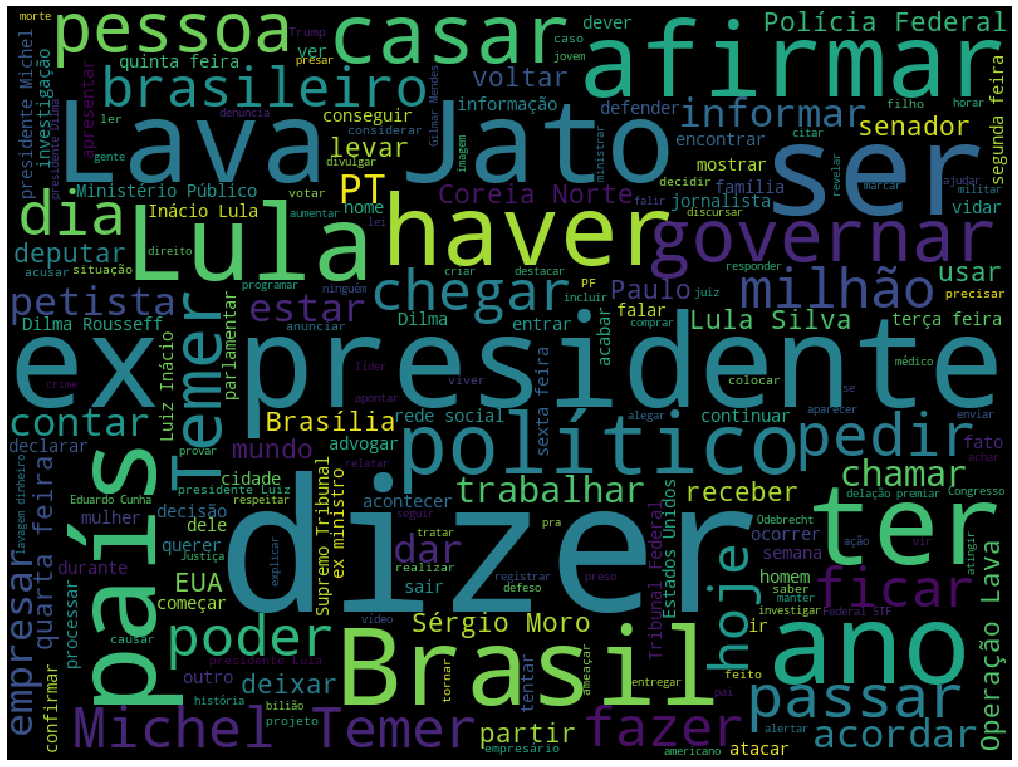

In [37]:
# Avaliar as palavras mais usadas em todo dataset
wordcloud_full = WordCloud( background_color='black', width=800, height=600)
nuvem = wordcloud_full.generate(' '.join(dados['texto_processado']))
plt.figure(figsize=(18,25))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

In [48]:
# remove pontuação para gerar lista somente de palavras para as próximas análises
lista_confiavel = re.sub(' +', ' ', re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', ' '.join(dados[dados['classe']==0]['texto_processado'])))
lista_falsa = re.sub(' +', ' ', re.sub(r'[^a-zA-ZÀ-ÿ]', ' ', ' '.join(dados[dados['classe']==1]['texto_processado'])))

In [49]:
# Gera nuvem de palavras para cada grupo
wc_confiavel = WordCloud( background_color='black', width=800, height=600)
nuvem_confiavel = wc_confiavel.generate(lista_confiavel)
wc_falsa = WordCloud( background_color='black', width=800, height=600)
nuvem_falsa = wc_falsa.generate(lista_falsa)

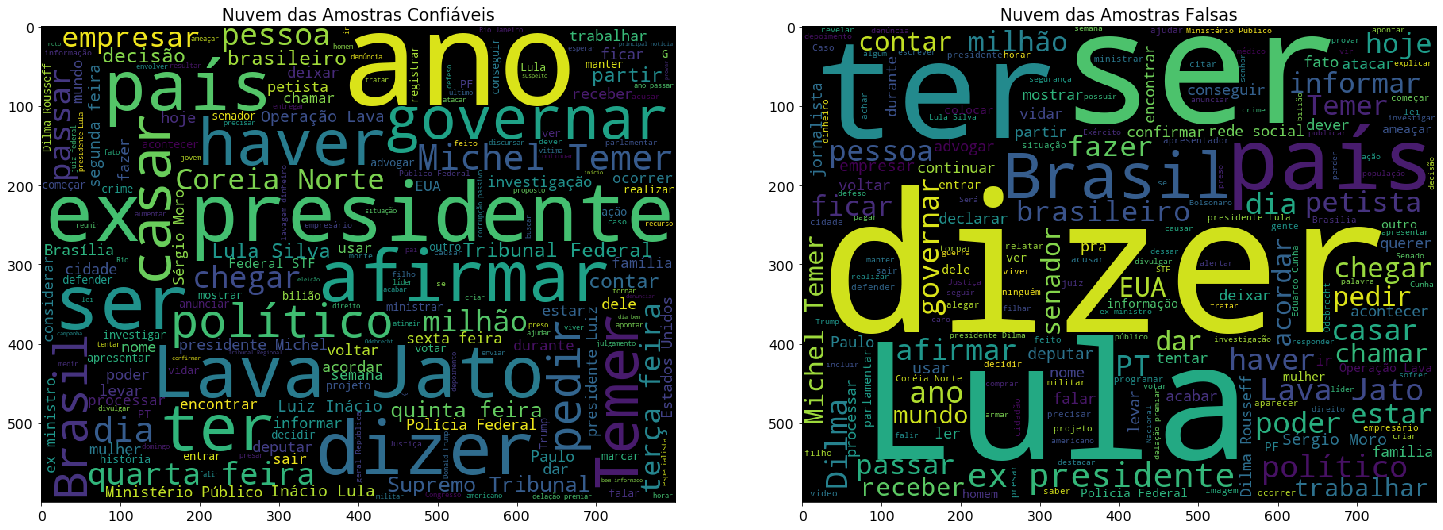

In [50]:
# Plots núvens lado a lado para comparar
f, plots = plt.subplots(nrows=1, ncols=2, figsize=(25, 45))
plots[0].imshow(nuvem_confiavel)
plots[0].set_title('Nuvem das Amostras Confiáveis')
plots[1].imshow(nuvem_falsa)
plots[1].set_title('Nuvem das Amostras Falsas')
plt.show()

In [51]:
import nltk
def avaliar_ngrams(corpus, title, n=2, top=20, plot_pos=None):
  serie_plot = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:top]
  serie_plot.sort_values().plot.barh(color='blue', width=.9, ax=plot_pos, title=title, figsize=(24, 8))

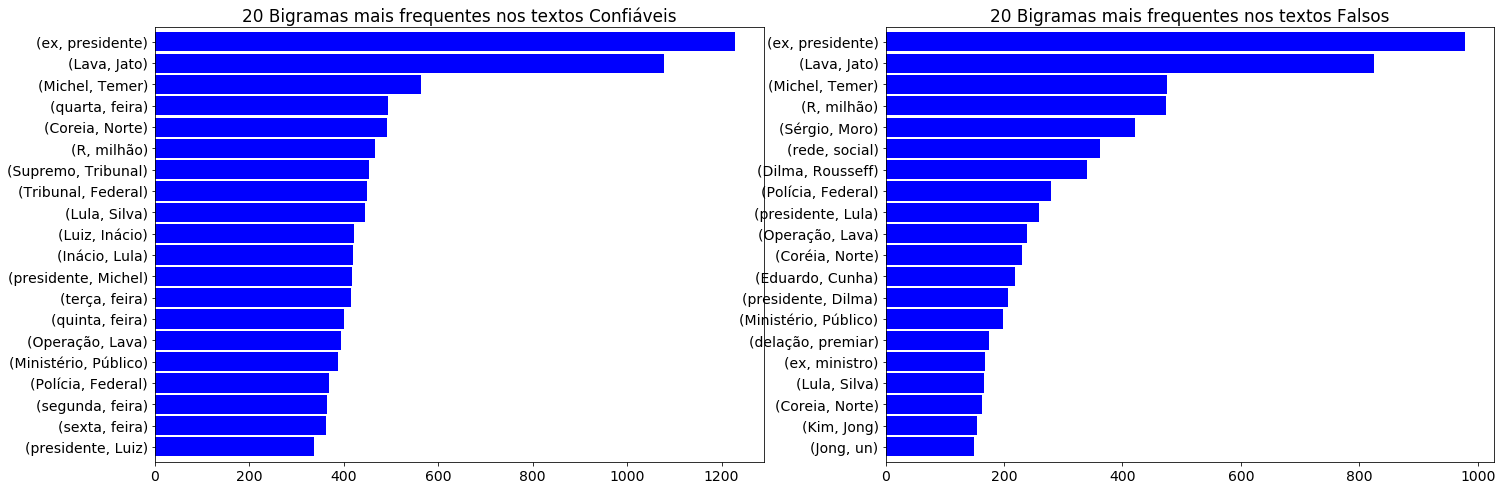

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2)
avaliar_ngrams(lista_confiavel, '20 Bigramas mais frequentes nos textos Confiáveis', plot_pos=axes[0])
avaliar_ngrams(lista_falsa, '20 Bigramas mais frequentes nos textos Falsos', plot_pos=axes[1])
#Penso em futuramente remover os primeiros ítems para evitar viés, e ou atualizar o corpus com notícias atuais, pois representa um ponto no tempo

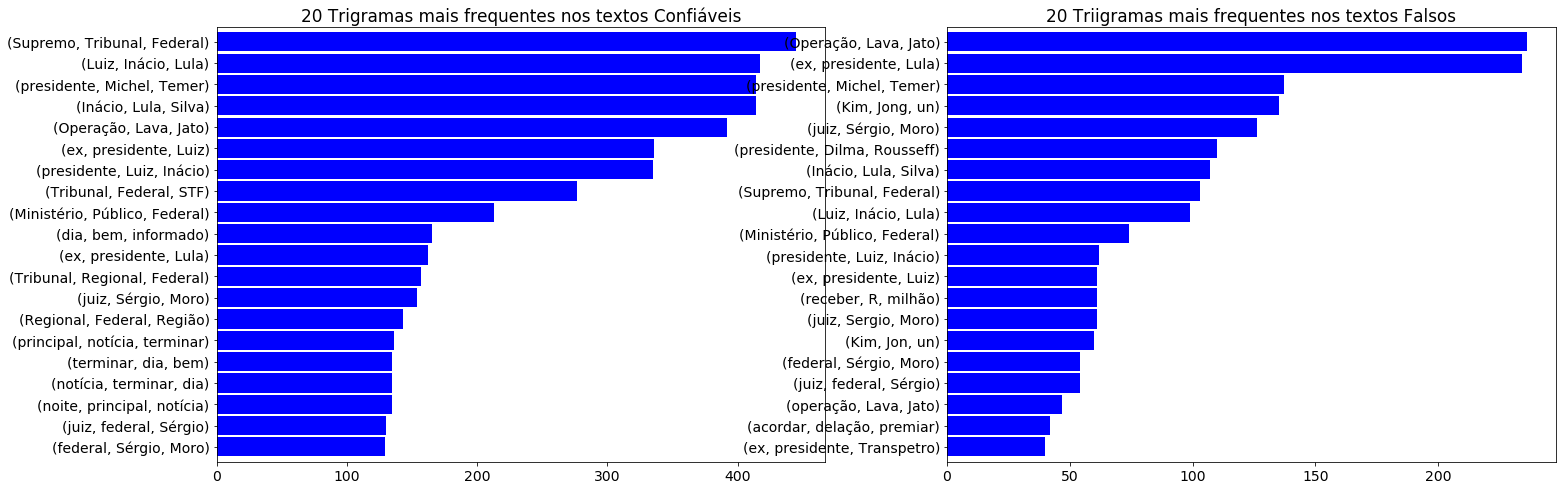

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2)
avaliar_ngrams(lista_confiavel, '20 Trigramas mais frequentes nos textos Confiáveis', n=3, plot_pos=axes[0])
avaliar_ngrams(lista_falsa, '20 Triigramas mais frequentes nos textos Falsos', n=3, plot_pos=axes[1])
#Com a visualização das trigramas dificulta fazer cortes, mas vejo que algumas trigramas se repetem em ordem diferente, 
# espero que o modelo BERT lide bem com isto, pois aqui estou usando o NLTK

In [54]:
# Salva dados para uso no notebook do próximo passo.
os.makedirs("dados/", exist_ok=True)
dados.to_csv('dados/fakebr_corpus_processado.csv', sep = ',', index = True)